# Notebook to make plots from saved files

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 
from jaxopt import LBFGS

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops, oasis
from src.algorithm import conjugate_gradient as cg
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
# We're working with this data:
# data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
# star_file = "particles_crossvalidation_train_1.star"

N0 = 105519
N = 50000
nx0 = 320
nx = 192
nx_crop = 192
pixel_size = 1.31
x_grid = [2.38549618e-03, 1.92000000e+02]
interp_method = "tri"

In [4]:
out_dir = '../data/out_dev/'


In [5]:
mask = jnp.load("../data/out_dev/mask.npy")
mask2d = mask[0].reshape(-1)


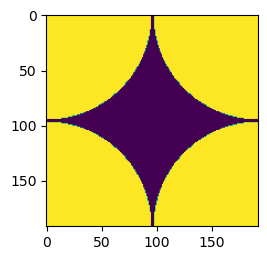

In [6]:
plt.rcParams["figure.figsize"]=6,6

plt.subplot(1,2,1)
plt.imshow(mask[0])

plt.rcParams["figure.figsize"]=6,6

### Preconditioner

In [7]:
#n_epochs = 2
n_epochs = 400

precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
D0 = jnp.load(precon_filename)


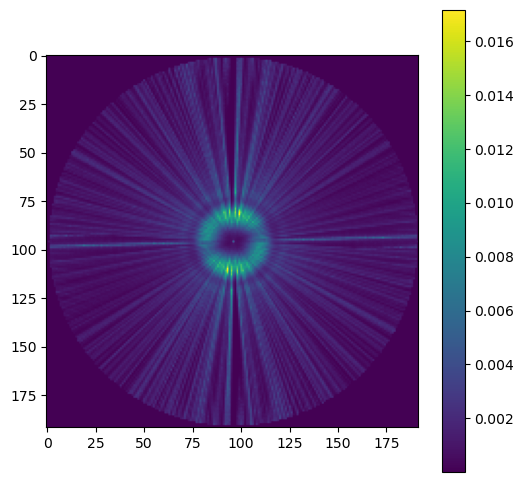

In [8]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0,:,:]))); plt.colorbar()


### Load iterates

In [9]:
iterates_file_root = f"{out_dir}/iterates_{interp_method}/"


In [10]:
iterates_rec = jnp.load(f"{iterates_file_root}/iterates_rec.npy")
loss_rec = jnp.load(f"{iterates_file_root}/iterates_rec_loss.npy")
step_sizes_rec = jnp.load(f"{iterates_file_root}/step_sizes_rec.npy")

In [11]:
iterates_p_rec1000 = jnp.load(f"{iterates_file_root}/iterates_p_rec1000.npy")
loss_p_rec1000 = jnp.load(f"{iterates_file_root}/iterates_p_rec1000_loss.npy")
step_sizes1000 = jnp.load(f"{iterates_file_root}/step_sizes_p_rec1000.npy")

In [12]:
iterates_o = jnp.load(f"{iterates_file_root}/iterates_o.npy")
loss_o = jnp.load(f"{iterates_file_root}/iterates_o_loss.npy")
step_sizes_o = jnp.load(f"{iterates_file_root}/step_sizes_o.npy")

### Load the L-BFGS volume

In [13]:
# Load
#nnstring = "nn_"
nnstring = ""
N_iters = 750

with mrcfile.open(f"{out_dir}//v_rec_lbfgs_{nnstring}{N_iters}_nx.mrc") as mrc:
    vr_lbfgs = mrc.data
    
v_lbfgs = jnp.fft.fftn(jnp.fft.fftshift((vr_lbfgs)))

In [14]:
# For the L-BFGS loss, copying the value from the grace notebook instead of computing it
loss_lbfgs = 1.56573577e+09

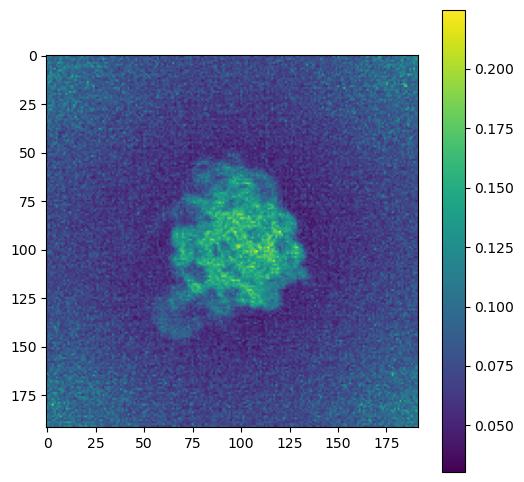

In [15]:
mip_z(vr_lbfgs)
plt.colorbar()

### Make plots

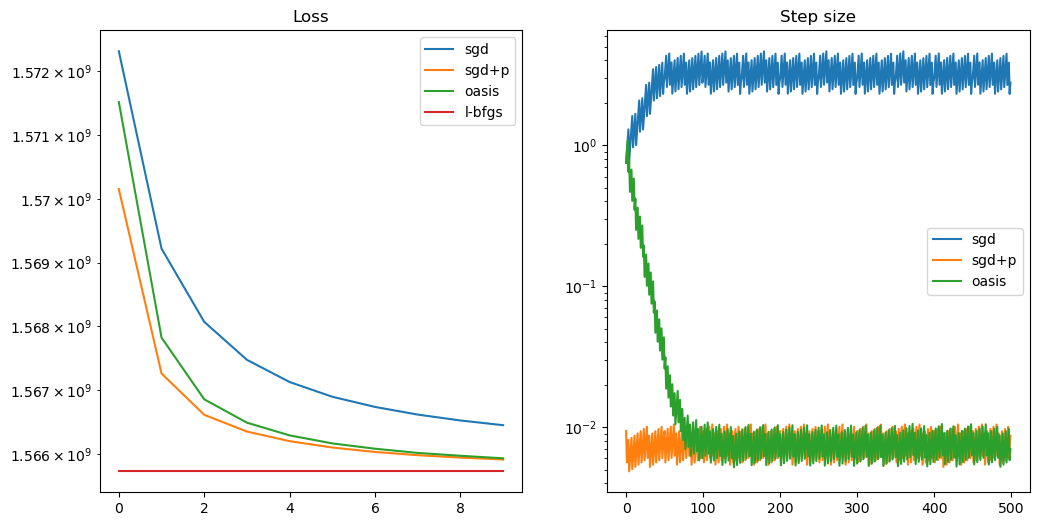

In [16]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(loss_rec)
plt.semilogy(loss_p_rec1000)
plt.semilogy(loss_o)
plt.semilogy(loss_lbfgs * jnp.ones(loss_rec.shape))
plt.legend(['sgd', 'sgd+p', 'oasis', 'l-bfgs'])
plt.title("Loss")

plt.subplot(122)
plt.semilogy(step_sizes_rec)
plt.semilogy(step_sizes1000)
plt.semilogy(step_sizes_o)
plt.legend(['sgd', 'sgd+p', 'oasis'])
plt.title("Step size")

plt.rcParams["figure.figsize"]=6,6

### Errors and FSCs

In [17]:
from src.fsc import average_shells

def err_px(v1, v2):
    err = 1/2 * jnp.real(jnp.conj(v1-v2)*(v1-v2))
    res, avg_err, n_pts, max_err, median_err = average_shells(err, x_grid)
    
    return jnp.array([avg_err, max_err, median_err])

err_px_iterates = jax.vmap(lambda vv : err_px(v_lbfgs, vv), in_axes=0, out_axes=1)
fsc_iterates = jax.vmap(lambda vv: calc_fsc(v_lbfgs, vv, [1, nx_crop]), in_axes=0, out_axes=1)

In [23]:
saved_measures_dir = "../data/out_dev/saved_measures/"
compute_measures = True
save_measures = False
load_measures = False

In [24]:
if compute_measures:
    averr_rec, maxerr_rec, mederr_rec = err_px_iterates(jnp.array(iterates_rec))
    averr_rec_p_1000, maxerr_rec_p_1000, mederr_rec_p_1000 = err_px_iterates(jnp.array(iterates_p_rec1000))
    averr_rec_o, maxerr_rec_o, mederr_rec_o = err_px_iterates(jnp.array(iterates_o))

    print(averr_rec.shape)
    print(maxerr_rec.shape)
    print(mederr_rec.shape)
    
if save_measures:
    jnp.save(f"{saved_measures_dir}/averr_rec", averr_rec)
    jnp.save(f"{saved_measures_dir}/maxerr_rec", maxerr_rec)
    jnp.save(f"{saved_measures_dir}/mederr_rec", mederr_rec)
    
if load_measures:
    averr_rec = jnp.load(f"{saved_measures_dir}/averr_rec.npy")
    maxerr_rec = jnp.load(f"{saved_measures_dir}/maxerr_rec.npy")
    mederr_rec = jnp.load(f"{saved_measures_dir}/mederr_rec.npy") 

(11, 55)
(11, 55)
(11, 55)


In [25]:
if compute_measures:
    res, fsc_sgd, shell_pts = fsc_iterates(jnp.array(iterates_rec))
    res, fsc_sgd_p, shell_pts = fsc_iterates(jnp.array(iterates_p_rec1000))
    res, fsc_o, shell_pts = fsc_iterates(jnp.array(iterates_o))

    print(fsc_sgd.shape)
    print(fsc_sgd_p.shape)
    print(fsc_o.shape)

(11, 55)
(11, 55)
(11, 55)


In [26]:
if compute_measures:
    # Lower thershold for the preconditioner
    # We take this to be the 1/(N points in the largest Fourier shell)
    _, _, shell_pts = calc_fsc(D0, D0, [1, D0.shape[0]])
    alpha = 1/jnp.max(shell_pts)
    print(alpha)
    D0hat = jnp.maximum(jnp.abs(D0), alpha)

    _, precon_radial_mean, _,  precon_radial_max, precon_radial_median = average_shells((1/D0hat), x_grid)
    _, D0_radial_mean, _,  D0_radial_max, D0_radial_median = average_shells(D0hat, x_grid)

5.213981813631434e-06


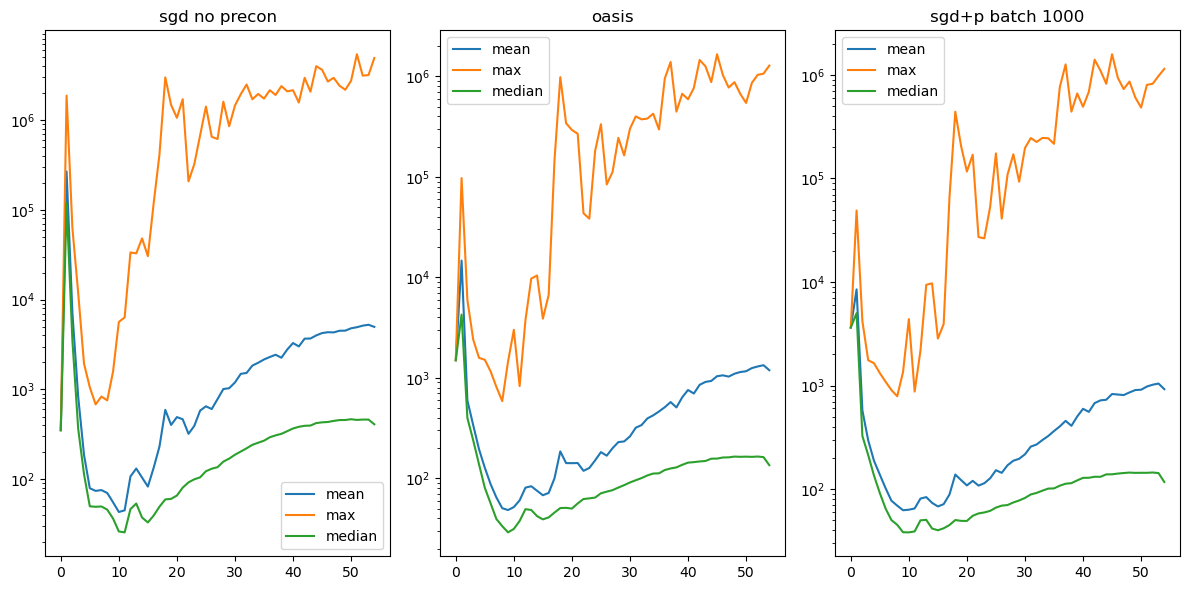

In [27]:
idx = 10

plt.rcParams["figure.figsize"]=12,6

plt.subplot(131)
plt.semilogy((averr_rec[idx]))
plt.semilogy((maxerr_rec[idx]))
plt.semilogy((mederr_rec[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('sgd no precon')
plt.tight_layout()

plt.subplot(132)
plt.semilogy((averr_rec_o[idx]))
plt.semilogy((maxerr_rec_o[idx]))
plt.semilogy((mederr_rec_o[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('oasis')
plt.tight_layout()

plt.subplot(133)
plt.semilogy((averr_rec_p_1000[idx]))
plt.semilogy((maxerr_rec_p_1000[idx]))
plt.semilogy((mederr_rec_p_1000[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('sgd+p batch 1000')

plt.rcParams["figure.figsize"]=6,6

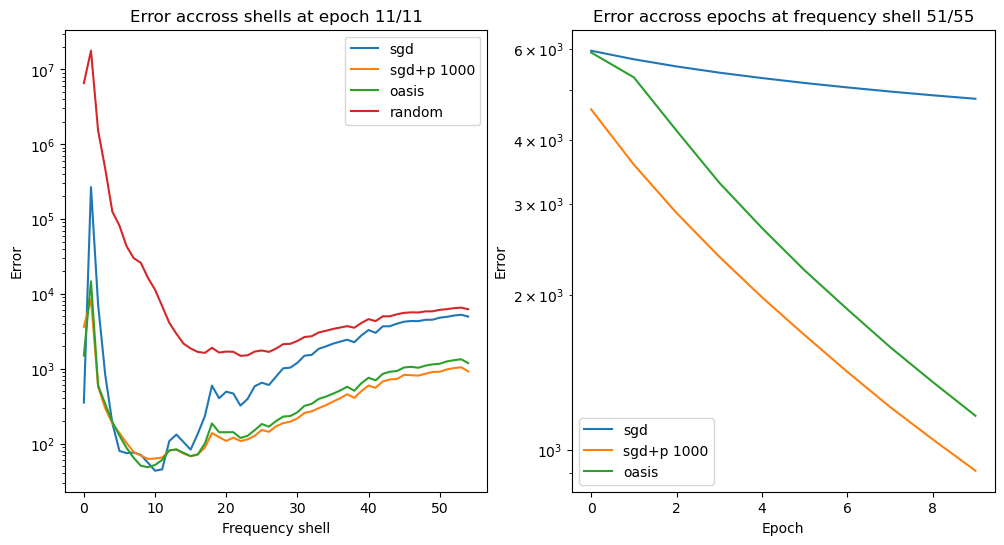

In [28]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)

idx = 10
plt.semilogy(averr_rec[idx])
plt.semilogy(averr_rec_p_1000[idx])
plt.semilogy(averr_rec_o[idx])
plt.semilogy(averr_rec[0])

plt.legend(['sgd', 'sgd+p 1000', 'oasis', 'random'])
plt.xlabel('Frequency shell')
plt.ylabel('Error')
plt.title(f'Error accross shells at epoch {idx+1}/{fsc_sgd.shape[0]}')

plt.subplot(122)

idx_shell = 50
plt.semilogy(averr_rec[1:,idx_shell])
plt.semilogy(averr_rec_p_1000[1:, idx_shell])
plt.semilogy(averr_rec_o[1:, idx_shell])

plt.legend(['sgd', 'sgd+p 1000', 'oasis'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title(f'Error accross epochs at frequency shell {idx_shell+1}/{fsc_sgd.shape[1]}')

plt.rcParams["figure.figsize"]=6,6

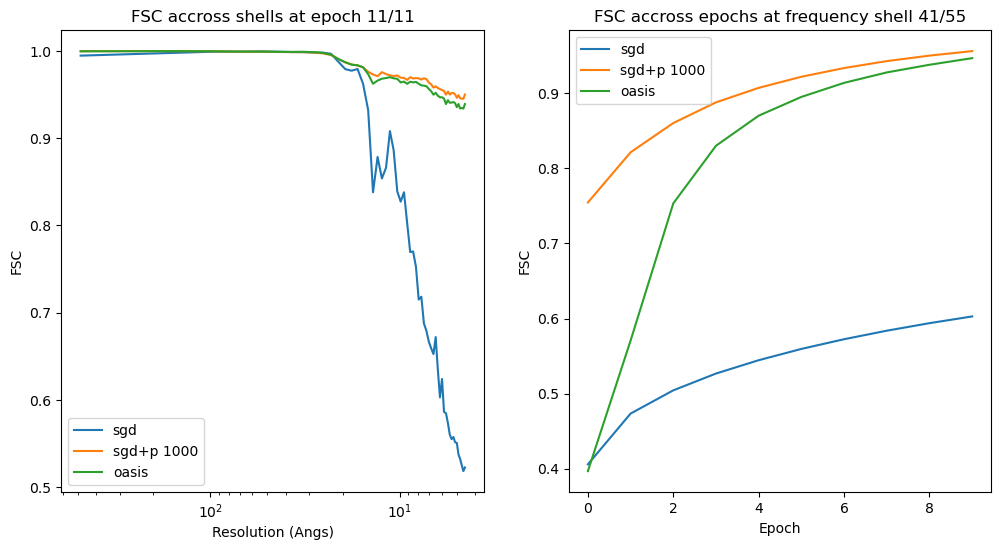

In [29]:
res_angs = nx0 * pixel_size/res[0]

plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)

idx = 10
plt.semilogx(res_angs[1:], fsc_sgd[idx,1:])
plt.semilogx(res_angs[1:], fsc_sgd_p[idx,1:])
plt.semilogx(res_angs[1:], fsc_o[idx,1:])

plt.gca().invert_xaxis()
plt.legend(['sgd', 'sgd+p 1000', 'oasis'])
plt.xlabel('Resolution (Angs)')
plt.ylabel('FSC')
plt.title(f'FSC accross shells at epoch {idx+1}/{fsc_sgd.shape[0]}')

plt.subplot(122)

idx_shell = 40
plt.plot(fsc_sgd[1:,idx_shell])
plt.plot(fsc_sgd_p[1:, idx_shell])
plt.plot(fsc_o[1:, idx_shell])

plt.legend(['sgd', 'sgd+p 1000', 'oasis'])
plt.xlabel('Epoch')
plt.ylabel('FSC')
plt.title(f'FSC accross epochs at frequency shell {idx_shell+1}/{fsc_sgd.shape[1]}')

plt.rcParams["figure.figsize"]=6,6

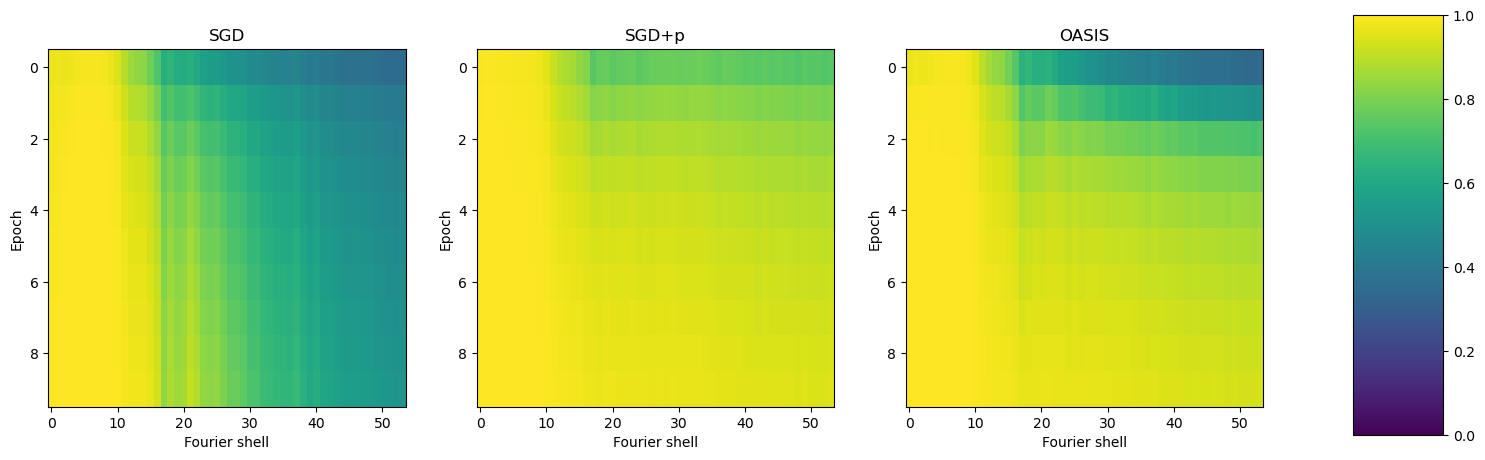

In [30]:
def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

plt.rcParams["figure.figsize"]=18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(fsc_sgd[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('SGD')

ax = fig.add_subplot(132)
ax.imshow(fsc_sgd_p[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('SGD+p')

ax = fig.add_subplot(133)
im = ax.imshow(fsc_o[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('OASIS')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

### And the preconditioner too

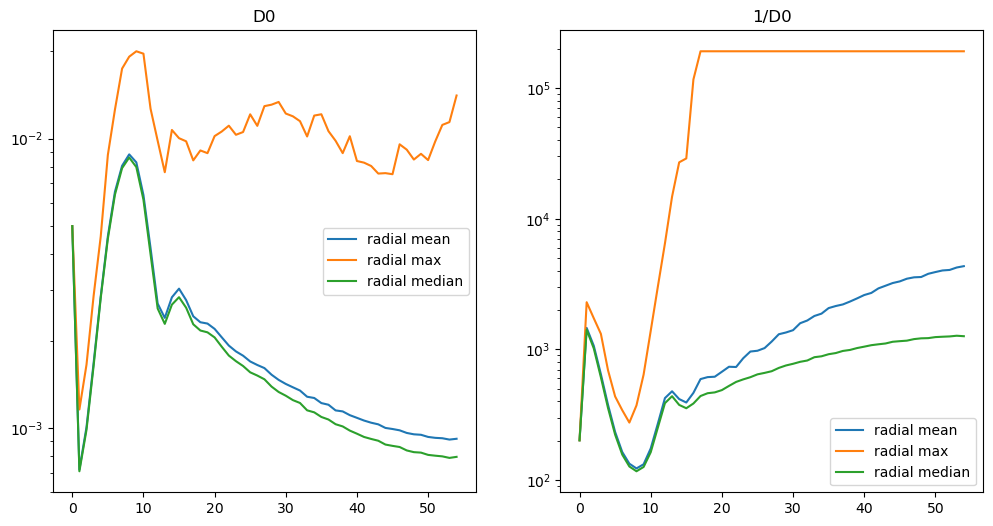

In [31]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(D0_radial_mean)
plt.semilogy(D0_radial_max)
plt.semilogy(D0_radial_median)
plt.legend(['radial mean', 'radial max', 'radial median'])
plt.title('D0')

plt.subplot(122)
plt.semilogy(precon_radial_mean)
plt.semilogy(precon_radial_max)
plt.semilogy(precon_radial_median)
plt.legend(['radial mean', 'radial max', 'radial median'])
plt.title('1/D0')

plt.rcParams["figure.figsize"]=6,6

### Gradient variance

In [32]:
grad_full = jnp.load(f"{saved_measures_dir}/grad_full.npy")
var_grad = jnp.load(f"{saved_measures_dir}/var_grad_1000.npy")

In [33]:
_, avgrad_full, _, _, _ = average_shells(jnp.abs(grad_full), x_grid) 
_, av_var_grad, _, _, _ = average_shells(var_grad, x_grid)

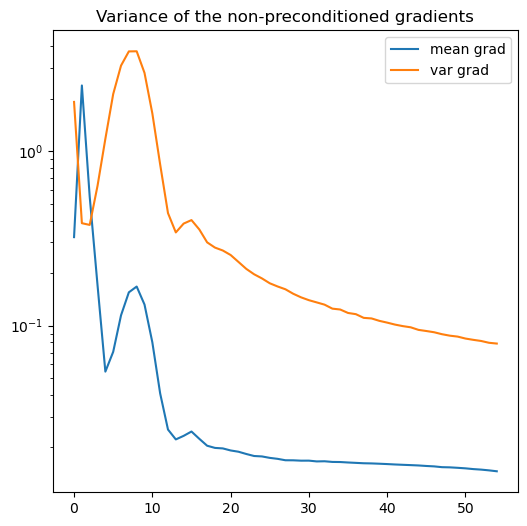

In [34]:
plt.semilogy(jnp.abs(avgrad_full))
plt.semilogy(jnp.abs(av_var_grad))

plt.title('Variance of the non-preconditioned gradients')
plt.legend(['mean grad', 'var grad'])

In [35]:
grad_full_p_d0 = jnp.load(f"{saved_measures_dir}/grad_full_p_d0.npy")
var_grad_p_d0 = jnp.load(f"{saved_measures_dir}/var_grad_1000_p_d0.npy")

In [36]:
_, avgrad_full_p_d0, _, _, _ = average_shells(jnp.abs(grad_full_p_d0), x_grid) 
_, av_var_grad_p_d0, _, _, _ = average_shells(var_grad_p_d0, x_grid)

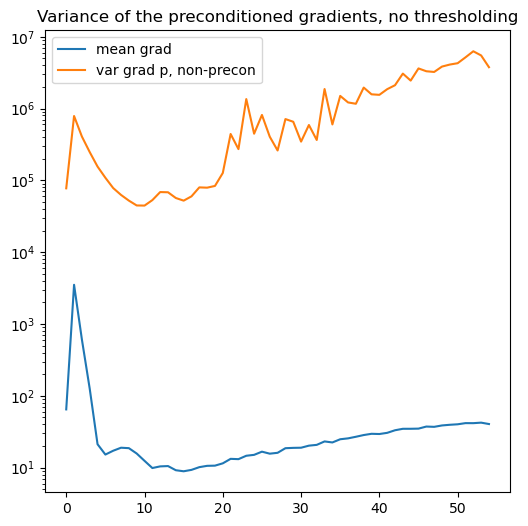

In [37]:
plt.semilogy(jnp.abs(avgrad_full_p_d0))
plt.semilogy(jnp.abs(av_var_grad_p_d0))

plt.title('Variance of the preconditioned gradients, no thresholding')
plt.legend(['mean grad', 'var grad p, non-precon'])

In [38]:
grad_full_p_dhat = jnp.load(f"{saved_measures_dir}/grad_full_p_dhat.npy")
var_grad_p_dhat = jnp.load(f"{saved_measures_dir}/var_grad_1000_p_dhat.npy")

In [39]:
_, avgrad_full_p_dhat, _, _, _ = average_shells(jnp.abs(grad_full_p_dhat), x_grid) 
_, av_var_grad_p_dhat, _, _, _ = average_shells(var_grad_p_dhat, x_grid)

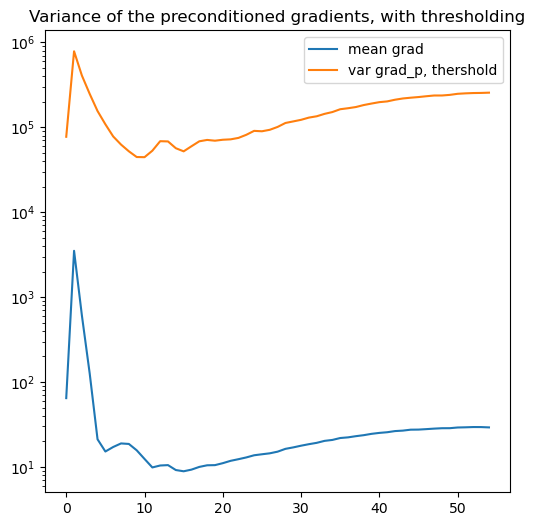

In [40]:
plt.semilogy(jnp.abs(avgrad_full_p_dhat))
plt.semilogy(jnp.abs(av_var_grad_p_dhat))

plt.title('Variance of the preconditioned gradients, with thresholding')
plt.legend(['mean grad', 'var grad_p, thershold'])

#### The error and the variance of the _preconditioned_ gradient go up at the same time, so they are related, so maybe their common thing is the problem: the preconditioner

In [41]:
# Before thresholding: TODO

# Now running on grace the _nothresh SGD stuff so I can generate these error plots too.

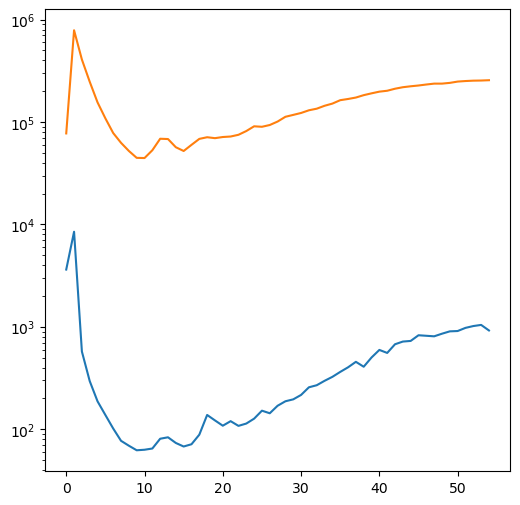

In [42]:
# After thresholding
plt.semilogy(averr_rec_p_1000[10])
plt.semilogy(jnp.abs(av_var_grad_p_dhat))
